Loading data from Mendalay.csv...
Loaded data shape: (11263, 6)
Columns: ['PM2.5 [ug/m3]', 'PM10[ug/m3]', 'Ozone [ppb]', 'Carbon_Monoxide [ppb]', 'Temperature [°C]', 'Relative_Humidity [%]']
Date range: 2022-01-31 12:00:00 to 2023-05-30 23:00:00

=== Training 5-hour forecast model ===
Feature shape: (11254, 10), Target shape: (11254, 10)
Training the model...
Iteration    | RMSE       | Time
----------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_2364\1176602751.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



=== Model Performance (Scaled Data) ===
Mean Squared Error: 0.1793
Mean Absolute Error: 0.2928
R² Score: 0.8204

=== Temperature Forecast Performance (Original Scale) ===
MSE: 4.6202
MAE: 1.4795
RMSE: 2.1495

=== Humidity Forecast Performance (Original Scale) ===
MSE: 84.0882
MAE: 6.3761
RMSE: 9.1700

Forecast visualization saved to 'plots/forecast_sample.png'
Error distribution saved to 'plots/error_distribution.png'
Model, scalers, and configuration saved to 'models/' directory with prefix 'mendalay_forecast_5h'

Training complete. 5-hour model saved successfully!


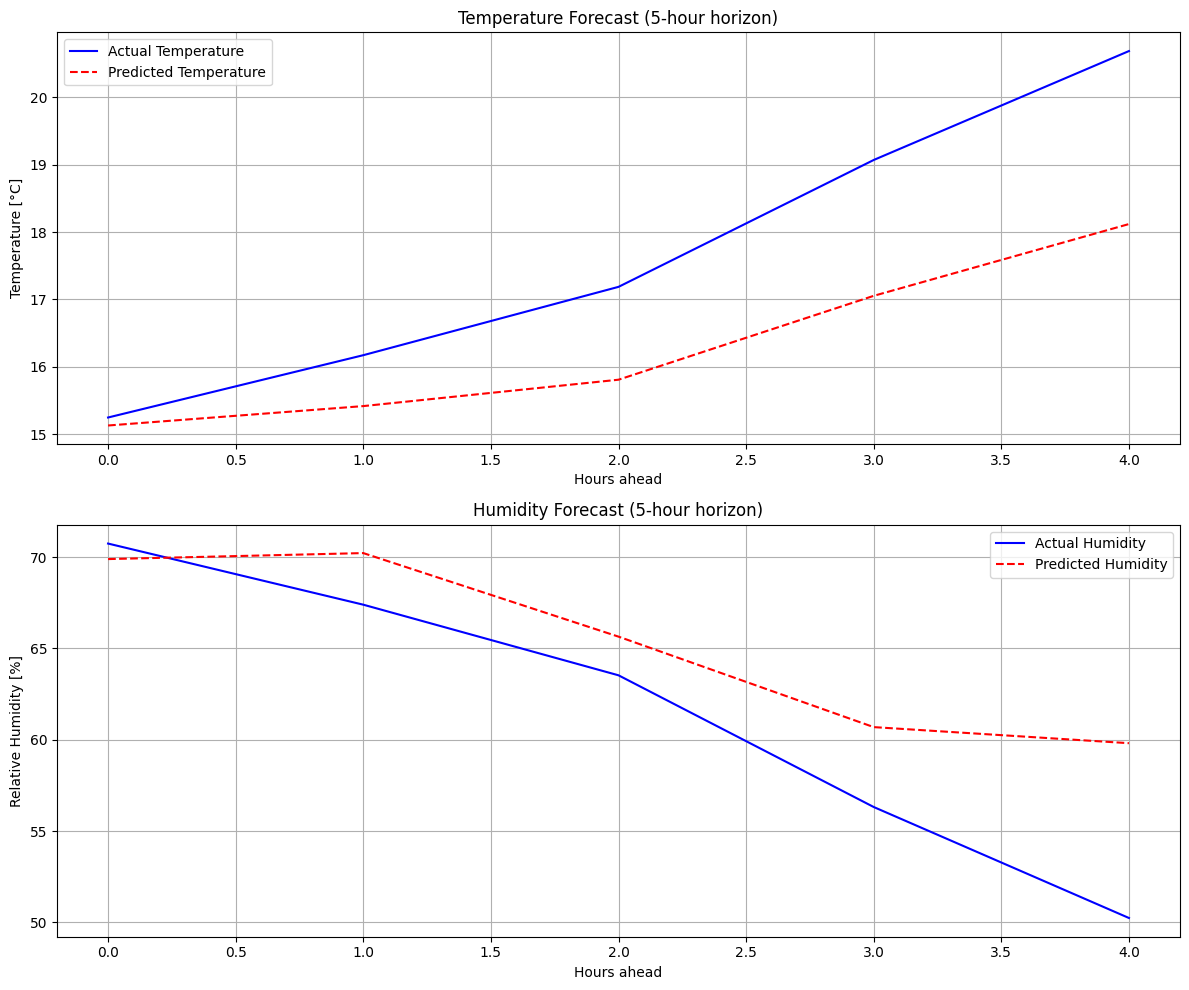

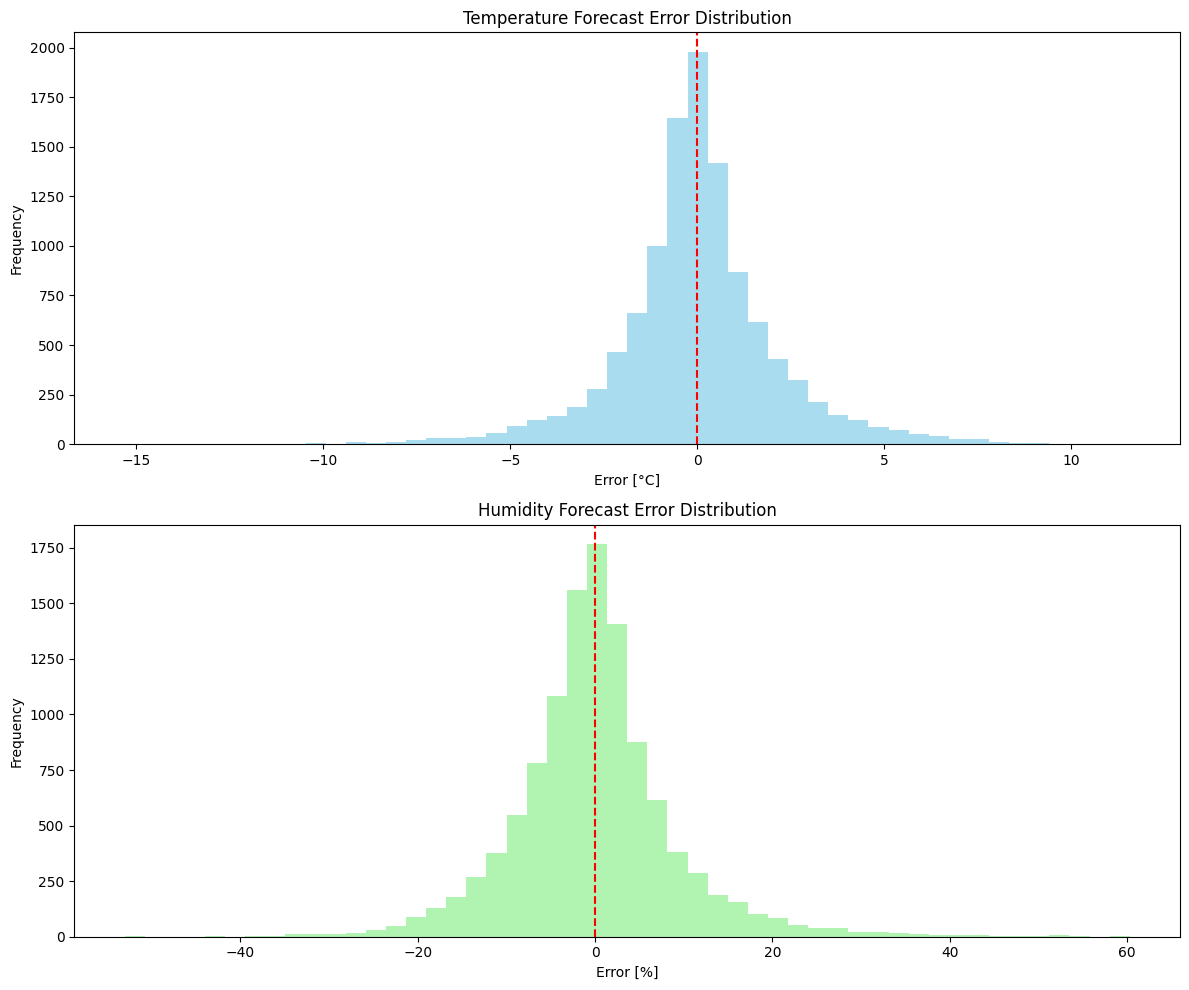

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import pickle
import os
import matplotlib.pyplot as plt
import difflib
from datetime import datetime

# Load and process the Mendalay.csv dataset
def load_mendalay_data(file_path="Mendalay.csv"):
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Check if 'Timestamp' column exists
        if 'Timestamp' not in df.columns:
            # Rename the first column to 'Timestamp'
            df = pd.read_csv(file_path, header=0)
            df.columns.values[0] = 'Timestamp'
        
        # Convert Timestamp to datetime format
        try:
            # Try DD/MM/YYYY format first
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
        except:
            try:
                # Try MM/DD/YYYY format if the first fails
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')
            except:
                # Use pandas' flexible parser as a fallback
                df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        # Set Timestamp as index
        df.set_index('Timestamp', inplace=True)
        
        # Ensure column names match what we need
        column_mapping = {
            'Temperature [Â°C]': 'Temperature [°C]',
            'Temperature [°C]': 'Temperature [°C]',
            'Relative_Humidity [%]': 'Relative_Humidity [%]',
            'Relative Humidity [%]': 'Relative_Humidity [%]',
            'RelativeHumidity [%]': 'Relative_Humidity [%]'
        }
        
        df.rename(columns=column_mapping, inplace=True)
        
        # Handle missing values if any
        df.fillna(method='ffill', inplace=True)
        
        print(f"Loaded data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Create features and targets for time series forecasting
def create_features_and_targets(df, n_past=5, n_future=5):
    X, y = [], []
    
    # Extract the columns we want to use
    temp_data = df['Temperature [°C]'].values
    humid_data = df['Relative_Humidity [%]'].values
    
    # Loop through the data to create sequences
    for i in range(len(df) - n_past - n_future + 1):
        # Past data (features)
        past_temp = temp_data[i:i+n_past]
        past_humid = humid_data[i:i+n_past]
        
        # Combine into a single feature vector
        past_features = np.concatenate([past_temp, past_humid])
        X.append(past_features)
        
        # Future data (targets)
        future_temp = temp_data[i+n_past:i+n_past+n_future]
        future_humid = humid_data[i+n_past:i+n_past+n_future]
        
        # Combine into a single target vector
        future_targets = np.concatenate([future_temp, future_humid])
        y.append(future_targets)
    
    return np.array(X), np.array(y)

# Custom callback to track training progress
class TrainingProgressCallback:
    def __init__(self, eval_set):
        self.eval_set = eval_set
        self.evals_result = {}
        self.progress = []
        self.start_time = datetime.now()
        
    def __call__(self, env):
        # Get evaluation data
        name, score, is_higher_better = env.evaluation_result_list[0]
        iteration = env.iteration
        elapsed = (datetime.now() - self.start_time).total_seconds()
        
        # Store results
        self.progress.append({
            'iteration': iteration,
            'score': score,
            'elapsed_time': elapsed
        })
        
        # Print progress every 10 iterations
        if iteration % 10 == 0:
            print(f"Iteration {iteration:4d} | {name}: {score:.6f} | Time: {elapsed:.2f}s")

# Train the forecasting model with progress tracking
def build_forecasting_model(df, n_past=5, n_future=5):
    # Create features and targets
    X, y = create_features_and_targets(df, n_past, n_future)
    
    print(f"Feature shape: {X.shape}, Target shape: {y.shape}")
    
    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    # Create model with evaluation metric
    base_model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        eval_metric='rmse'
    )
    
    # Set up eval set and callback
    eval_set = [(X_test, y_test[:, 0])]  # Track first target for progress
    callback = TrainingProgressCallback(eval_set)
    
    # Create and train the model
    model = MultiOutputRegressor(base_model)
    
    print("Training the model...")
    print("Iteration    | RMSE       | Time")
    print("-" * 40)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Un-scale predictions and actual values for better interpretability
    y_test_orig = scaler_y.inverse_transform(y_test)
    y_pred_orig = scaler_y.inverse_transform(y_pred)
    
    # Calculate metrics on scaled data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\n=== Model Performance (Scaled Data) ===")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Calculate metrics for temperature and humidity separately (on original scale)
    temp_mse = mean_squared_error(y_test_orig[:, :n_future], y_pred_orig[:, :n_future])
    temp_mae = mean_absolute_error(y_test_orig[:, :n_future], y_pred_orig[:, :n_future])
    temp_rmse = np.sqrt(temp_mse)
    
    humid_mse = mean_squared_error(y_test_orig[:, n_future:], y_pred_orig[:, n_future:])
    humid_mae = mean_absolute_error(y_test_orig[:, n_future:], y_pred_orig[:, n_future:])
    humid_rmse = np.sqrt(humid_mse)
    
    print("\n=== Temperature Forecast Performance (Original Scale) ===")
    print(f"MSE: {temp_mse:.4f}")
    print(f"MAE: {temp_mae:.4f}")
    print(f"RMSE: {temp_rmse:.4f}")
    
    print("\n=== Humidity Forecast Performance (Original Scale) ===")
    print(f"MSE: {humid_mse:.4f}")
    print(f"MAE: {humid_mae:.4f}")
    print(f"RMSE: {humid_rmse:.4f}")
    
    # Visualize results
    plot_forecast_results(y_test_orig, y_pred_orig, n_future)
    
    return model, scaler_X, scaler_y, callback.progress

# Plot forecast results
def plot_forecast_results(y_true, y_pred, n_future):
    # Create directory for plots
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Select a random sample to visualize
    sample_idx = np.random.randint(0, len(y_true))
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot temperature
    axes[0].plot(range(n_future), y_true[sample_idx, :n_future], 'b-', label='Actual Temperature')
    axes[0].plot(range(n_future), y_pred[sample_idx, :n_future], 'r--', label='Predicted Temperature')
    axes[0].set_title('Temperature Forecast (5-hour horizon)')
    axes[0].set_xlabel('Hours ahead')
    axes[0].set_ylabel('Temperature [°C]')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot humidity
    axes[1].plot(range(n_future), y_true[sample_idx, n_future:], 'b-', label='Actual Humidity')
    axes[1].plot(range(n_future), y_pred[sample_idx, n_future:], 'r--', label='Predicted Humidity')
    axes[1].set_title('Humidity Forecast (5-hour horizon)')
    axes[1].set_xlabel('Hours ahead')
    axes[1].set_ylabel('Relative Humidity [%]')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('plots/forecast_sample.png')
    
    # Plot error distribution
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Temperature error
    temp_errors = y_true[:, :n_future] - y_pred[:, :n_future]
    axes[0].hist(temp_errors.flatten(), bins=50, color='skyblue', alpha=0.7)
    axes[0].axvline(0, color='r', linestyle='--')
    axes[0].set_title('Temperature Forecast Error Distribution')
    axes[0].set_xlabel('Error [°C]')
    axes[0].set_ylabel('Frequency')
    
    # Humidity error
    humid_errors = y_true[:, n_future:] - y_pred[:, n_future:]
    axes[1].hist(humid_errors.flatten(), bins=50, color='lightgreen', alpha=0.7)
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_title('Humidity Forecast Error Distribution')
    axes[1].set_xlabel('Error [%]')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('plots/error_distribution.png')
    
    print("\nForecast visualization saved to 'plots/forecast_sample.png'")
    print("Error distribution saved to 'plots/error_distribution.png'")

# Save the model and scalers
def save_model(model, scaler_X, scaler_y, n_past, n_future, prefix="mendalay_forecast"):
    # Create directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save model
    with open(f'models/{prefix}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    # Save scalers
    with open(f'models/{prefix}_scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
    with open(f'models/{prefix}_scaler_y.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)
        
    # Save the configuration (n_past, n_future)
    config = {
        'n_past': n_past,
        'n_future': n_future
    }
    
    with open(f'models/{prefix}_config.pkl', 'wb') as f:
        pickle.dump(config, f)
    
    print(f"Model, scalers, and configuration saved to 'models/' directory with prefix '{prefix}'")

# Train and save only the 5-hour model
def main():
    # Load data
    print("Loading data from Mendalay.csv...")
    data = load_mendalay_data()
    
    # Keep only temperature and humidity columns
    required_columns = ['Temperature [°C]', 'Relative_Humidity [%]']
    
    # Check if these columns exist in the data
    for col in required_columns:
        if col not in data.columns:
            closest_match = difflib.get_close_matches(col, data.columns, n=1)
            if closest_match:
                print(f"Column '{col}' not found, using '{closest_match[0]}' instead")
                data.rename(columns={closest_match[0]: col}, inplace=True)
            else:
                print(f"Column '{col}' not found and no close match available")
                return
    
    data = data[required_columns]
    
    # Build and train 5-hour model with progress tracking
    print("\n=== Training 5-hour forecast model ===")
    model_5h, scaler_X_5h, scaler_y_5h, progress = build_forecasting_model(data, n_past=5, n_future=5)
    
    # Plot training progress
    if progress:
        plt.figure(figsize=(10, 6))
        iterations = [p['iteration'] for p in progress]
        scores = [p['score'] for p in progress]
        plt.plot(iterations, scores)
        plt.title('Training Progress')
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.savefig('plots/training_progress.png')
        print("Training progress plot saved to 'plots/training_progress.png'")
    
    # Save 5-hour model
    save_model(model_5h, scaler_X_5h, scaler_y_5h, n_past=5, n_future=5, prefix="mendalay_forecast_5h")
    
    print("\nTraining complete. 5-hour model saved successfully!")

if __name__ == "__main__":
    main()

LOADING THE MODEL

Weather Forecasting Prediction System
Model and scalers loaded successfully for 5h forecasting

Loaded 5h forecasting model (using past 5 hours to predict next 5 hours)

Please enter temperature and humidity data for the past 5 hours.
Start with the oldest data point and move forward in time.
Invalid date format. Please use YYYY-MM-DD HH:MM format.

===== INPUT DATA =====
Timestamp               | Temperature (°C) | Humidity (%)
------------------------------------------------------------
2025-04-13 06:21 |           22.00 |       45.00
2025-04-13 07:21 |           24.00 |       40.00
2025-04-13 08:21 |           28.00 |       50.00
2025-04-13 09:21 |           25.00 |       33.00
2025-04-13 10:21 |           27.00 |       39.00

===== FORECAST RESULTS =====
Timestamp               | Temperature (°C) | Humidity (%)
------------------------------------------------------------
2025-04-13 11:21 |           25.41 |       43.78
2025-04-13 12:21 |           22.50 |       53.10
2025-04-13 13:

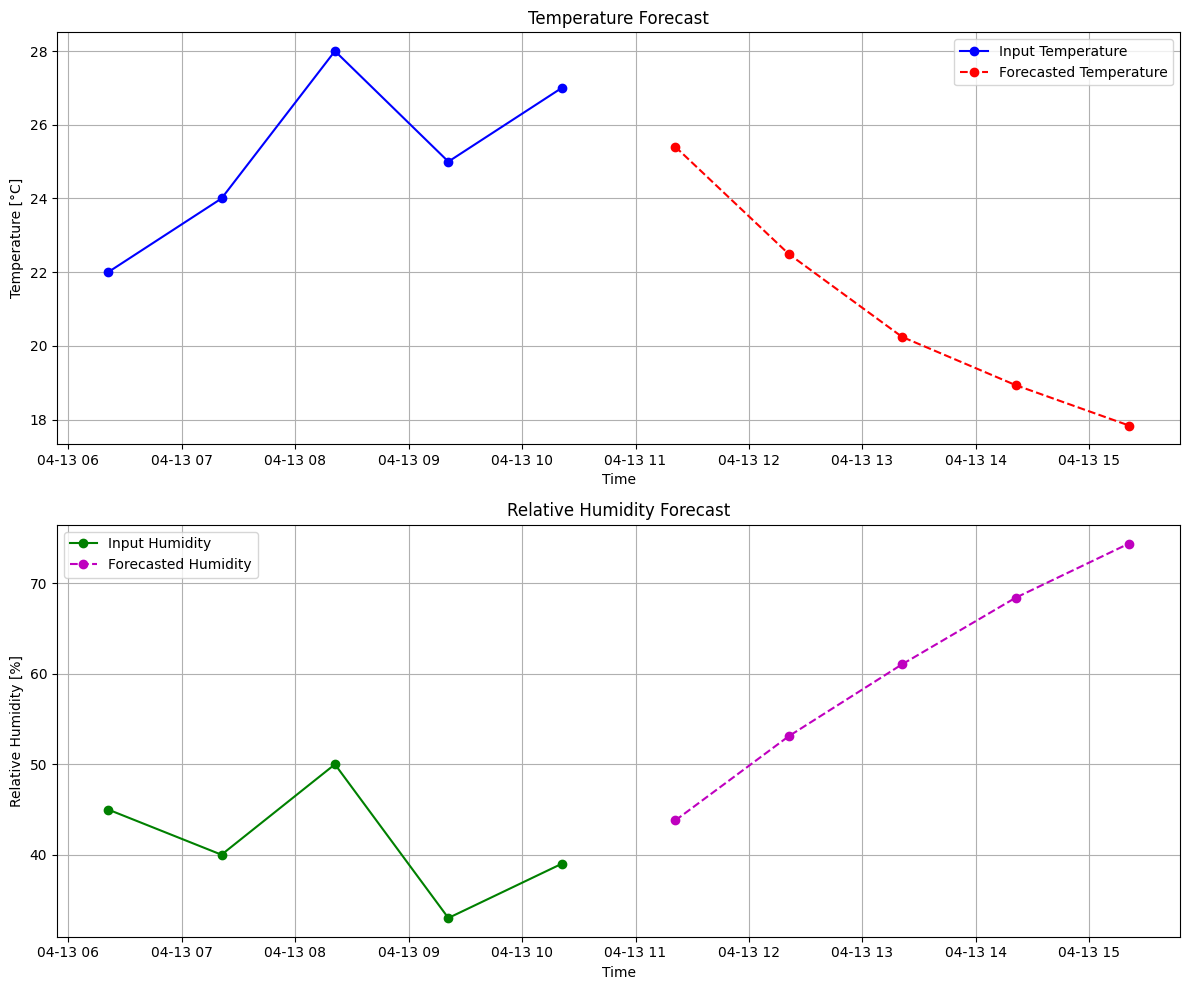


Forecast saved to 'forecast_results.csv'


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the 5-hour model and scalers
def load_model():
    """
    Load the trained 5-hour model, scalers, and configuration
    
    Returns:
    model: Trained forecasting model
    scaler_X: Feature scaler
    scaler_y: Target scaler
    config: Model configuration
    """
    prefix = "mendalay_forecast_5h"
    
    try:
        # Load model
        with open(f'models/{prefix}_model.pkl', 'rb') as f:
            model = pickle.load(f)
        
        # Load scalers
        with open(f'models/{prefix}_scaler_X.pkl', 'rb') as f:
            scaler_X = pickle.load(f)
        
        with open(f'models/{prefix}_scaler_y.pkl', 'rb') as f:
            scaler_y = pickle.load(f)
            
        # Load configuration
        with open(f'models/{prefix}_config.pkl', 'rb') as f:
            config = pickle.load(f)
        
        print("5-hour forecasting model loaded successfully")
        
        return model, scaler_X, scaler_y, config
    
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Please make sure you've run the training script first.")
        return None, None, None, None

# Function to get user input
def get_user_input(n_past):
    """
    Get temperature and humidity values from the user
    
    Parameters:
    n_past: Number of past hours to collect data for
    
    Returns:
    temperatures: List of temperature values
    humidities: List of humidity values
    start_time: Starting timestamp for forecasting
    """
    print(f"\nPlease enter temperature and humidity data for the past {n_past} hours.")
    print("Start with the oldest data point and move forward in time.")
    
    temperatures = []
    humidities = []
    
    for i in range(n_past):
        hour_label = f"{i+1}/{n_past}"
        
        while True:
            try:
                temp = float(input(f"Hour {hour_label} - Temperature [°C]: "))
                humid = float(input(f"Hour {hour_label} - Relative Humidity [%]: "))
                break
            except ValueError:
                print("Please enter valid numerical values.")
        
        temperatures.append(temp)
        humidities.append(humid)
    
    # Get the timestamp for the most recent data point
    while True:
        try:
            time_str = input("\nEnter the timestamp for the most recent data point (YYYY-MM-DD HH:MM): ")
            start_time = datetime.strptime(time_str, "%Y-%m-%d %H:%M")
            break
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD HH:MM format.")
    
    return temperatures, humidities, start_time

# Function to make predictions
def forecast_weather(model, scaler_X, scaler_y, temps, humids, n_past, n_future):
    """
    Forecasts the next n_future hours based on input data
    
    Parameters:
    model: Trained forecasting model
    scaler_X: Feature scaler
    scaler_y: Target scaler
    temps: List of temperature values
    humids: List of humidity values
    n_past: Number of past time steps used as input features
    n_future: Number of future time steps to predict
    
    Returns:
    temp_forecast: Forecasted temperature values
    humid_forecast: Forecasted humidity values
    """
    # Combine into feature vector
    features = np.concatenate([temps, humids]).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler_X.transform(features)
    
    # Make prediction
    forecast_scaled = model.predict(features_scaled)
    
    # Inverse transform
    forecast = scaler_y.inverse_transform(forecast_scaled)
    
    # Separate temperature and humidity forecasts
    temp_forecast = forecast[0][:n_future]
    humid_forecast = forecast[0][n_future:]
    
    return temp_forecast, humid_forecast

# Function to display results
def display_results(temps, humids, temp_forecast, humid_forecast, start_time, n_past, n_future):
    """
    Display the input data and forecast results
    
    Parameters:
    temps: Input temperature values
    humids: Input humidity values
    temp_forecast: Forecasted temperature values
    humid_forecast: Forecasted humidity values
    start_time: Starting timestamp for the most recent input data
    n_past: Number of past time steps used as input features
    n_future: Number of future time steps predicted
    """
    # Create timestamps for past data
    past_times = [(start_time - timedelta(hours=n_past-i-1)) for i in range(n_past)]
    
    # Create timestamps for future data
    future_times = [(start_time + timedelta(hours=i+1)) for i in range(n_future)]
    
    # Print tabular results
    print("\n===== INPUT DATA =====")
    print("Timestamp               | Temperature (°C) | Humidity (%)")
    print("-" * 60)
    for i in range(n_past):
        time_str = past_times[i].strftime("%Y-%m-%d %H:%M")
        print(f"{time_str} | {temps[i]:15.2f} | {humids[i]:11.2f}")
    
    print("\n===== FORECAST RESULTS =====")
    print("Timestamp               | Temperature (°C) | Humidity (%)")
    print("-" * 60)
    for i in range(n_future):
        time_str = future_times[i].strftime("%Y-%m-%d %H:%M")
        print(f"{time_str} | {temp_forecast[i]:15.2f} | {humid_forecast[i]:11.2f}")
    
    # Create DataFrames for plotting
    past_df = pd.DataFrame({
        'Timestamp': past_times,
        'Temperature [°C]': temps,
        'Relative_Humidity [%]': humids
    })
    past_df.set_index('Timestamp', inplace=True)
    
    future_df = pd.DataFrame({
        'Timestamp': future_times,
        'Temperature [°C]': temp_forecast,
        'Relative_Humidity [%]': humid_forecast
    })
    future_df.set_index('Timestamp', inplace=True)
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot temperature
    ax1.plot(past_df.index, past_df['Temperature [°C]'], 'b-o', label='Input Temperature')
    ax1.plot(future_df.index, future_df['Temperature [°C]'], 'r--o', label='Forecasted Temperature')
    ax1.set_title('Temperature Forecast')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature [°C]')
    ax1.legend()
    ax1.grid(True)
    
    # Plot humidity
    ax2.plot(past_df.index, past_df['Relative_Humidity [%]'], 'g-o', label='Input Humidity')
    ax2.plot(future_df.index, future_df['Relative_Humidity [%]'], 'm--o', label='Forecasted Humidity')
    ax2.set_title('Relative Humidity Forecast')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Relative Humidity [%]')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Save the forecast to a CSV file
    combined_df = pd.concat([past_df, future_df])
    combined_df.to_csv('forecast_results.csv')
    print("\nForecast saved to 'forecast_results.csv'")

# Main function
def main():
    print("======================================")
    print("5-Hour Weather Forecasting System")
    print("======================================")
    
    # Load the 5-hour model
    model, scaler_X, scaler_y, config = load_model()
    
    if model is None:
        return
    
    n_past = config['n_past']
    n_future = config['n_future']
    
    print(f"\nUsing past {n_past} hours to predict next {n_future} hours")
    
    # Get user input
    temps, humids, start_time = get_user_input(n_past)
    
    # Make prediction
    temp_forecast, humid_forecast = forecast_weather(
        model, scaler_X, scaler_y, temps, humids, n_past, n_future
    )
    
    # Display results
    display_results(temps, humids, temp_forecast, humid_forecast, start_time, n_past, n_future)

if __name__ == "__main__":
    main()